### BEAM PROFILE - AFTER L4

Figure saved → /Users/asca/Documents/University/Master Thesis/code/Data/slit scanning beam profiler/20251016_telescoping/fig/beam_profile_after_L4_XY_separate_insets.png

=== Minimum waist from linear fit intersection ===
X-direction: w₀,x = 20.9 µm at Z = 10.197 mm
Y-direction: w₀,y = 20.7 µm at Z = 10.121 mm


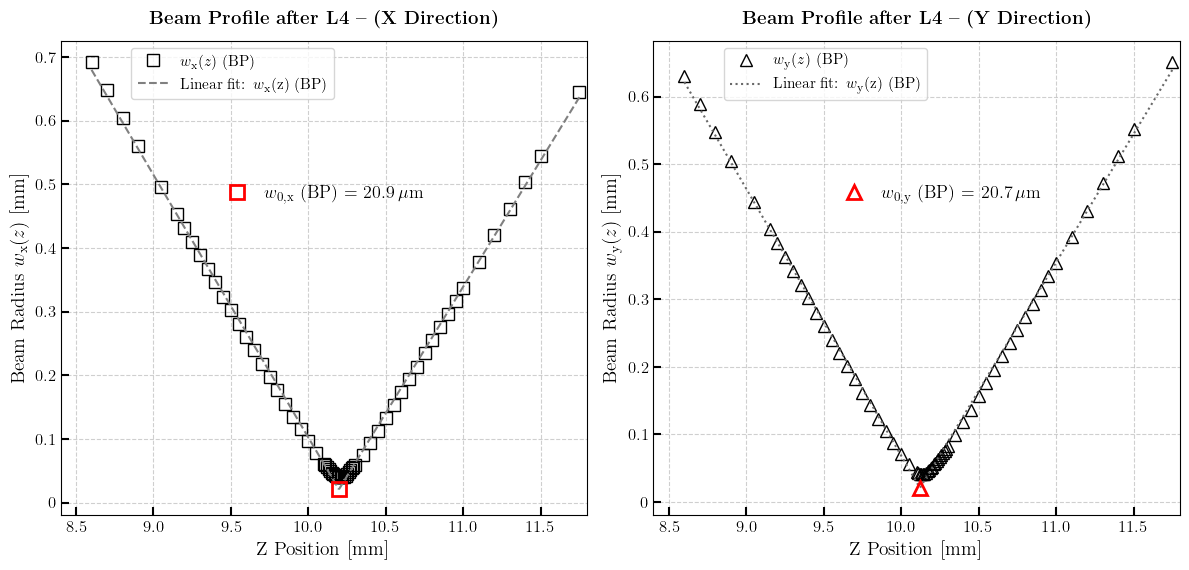

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

# ---------------------- Font & Style ----------------------
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# Custom Y-tick formatter: show "0" instead of "0.0", others with one decimal
def y_formatter(val, pos):
    return '0' if abs(val) < 1e-10 else f'{val:.1f}'
y_fmt = FuncFormatter(y_formatter)

# ---------------------- Data Loading ----------------------
data_path = "/Users/asca/Documents/University/Master Thesis/code/Data/slit scanning beam profiler/20251016_telescoping"
file_list = sorted(
    [f for f in glob.glob(os.path.join(data_path, "*[m|mm]_#001.txt"))
     if "before lens" not in os.path.basename(f).lower() and
     float(os.path.basename(f).split('m')[0].strip()) <= 16],
    key=lambda f: float(os.path.basename(f).split('m')[0])
)

fig_dir = os.path.join(data_path, "fig")
os.makedirs(fig_dir, exist_ok=True)

z_values, width_x, width_y = [], [], []

for file in file_list:
    z_str = os.path.basename(file).split('m')[0].strip()
    try:
        z = float(z_str)
    except:
        continue
    with open(file, 'r', encoding='latin1') as f:
        lines = f.readlines()
    wx_dia = wy_dia = None
    for line in lines:
        if line.strip() and line.split('\t')[0].isdigit():
            parts = line.strip().split('\t')
            try:
                wx_dia = float(parts[19])
                wy_dia = float(parts[20])
            except:
                continue
            break
    if wx_dia and wy_dia:
        z_values.append(z)
        width_x.append(wx_dia / 2 / 1000)   # radius in mm
        width_y.append(wy_dia / 2 / 1000)

z_values = np.array(z_values)
width_x = np.array(width_x)
width_y = np.array(width_y)

# Sort and filter
order = np.argsort(z_values)
z_values = z_values[order]
width_x = width_x[order]
width_y = width_y[order]

mask = (z_values >= 8.5) & (z_values <= 11.75)
z_filt = z_values[mask]
wx_filt = width_x[mask]
wy_filt = width_y[mask]

# ---------------------- Intersection Finder ----------------------
def find_intersection(fit1, fit2):
    m1, b1 = fit1
    m2, b2 = fit2
    if abs(m1 - m2) < 1e-12:
        return np.nan, np.nan
    z_int = (b2 - b1) / (m1 - m2)
    w_int = m1 * z_int + b1
    return z_int, w_int

# Fit arms (X)
idx_min_x = np.argmin(wx_filt)
z_left_x, wx_left = z_filt[:idx_min_x], wx_filt[:idx_min_x]
z_right_x, wx_right = z_filt[idx_min_x:], wx_filt[idx_min_x:]
fit_left_x  = np.polyfit(z_left_x,  wx_left,  1) if len(z_left_x)  > 1 else [0, 0]
fit_right_x = np.polyfit(z_right_x, wx_right, 1) if len(z_right_x) > 1 else [0, 0]
z0_x, w0_x_mm = find_intersection(fit_left_x, fit_right_x)
w0_x = w0_x_mm * 1000  # µm

# Fit arms (Y)
idx_min_y = np.argmin(wy_filt)
z_left_y, wy_left = z_filt[:idx_min_y], wy_filt[:idx_min_y]
z_right_y, wy_right = z_filt[idx_min_y:], wy_filt[idx_min_y:]
fit_left_y  = np.polyfit(z_left_y,  wy_left,  1) if len(z_left_y)  > 1 else [0, 0]
fit_right_y = np.polyfit(z_right_y, wy_right, 1) if len(z_right_y) > 1 else [0, 0]
z0_y, w0_y_mm = find_intersection(fit_left_y, fit_right_y)
w0_y = w0_y_mm * 1000  # µm

# Extend fits to intersection
def extend_fit(z_data, coeffs, z_target):
    if len(z_data) == 0 or np.isnan(z_target):
        return np.array([]), np.array([])
    z_start = z_data[0] if z_data[-1] < z_target else z_data[-1]
    z_ext = np.linspace(z_start, z_target, 60)
    w_ext = np.polyval(coeffs, z_ext)
    return z_ext, w_ext

# ---------------------- Plot ----------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.8))

# === X Direction ===
ax1.plot(z_filt, wx_filt, 's', mfc='none', mec='black', ms=8, label=r'$w_{\rm{{x}}}(z)$ (BP)')
if len(z_left_x) > 1 and not np.isnan(z0_x):
    zl, wl = extend_fit(z_left_x,  fit_left_x,  z0_x)
    zr, wr = extend_fit(z_right_x, fit_right_x, z0_x)
    ax1.plot(zl, wl, '--', color='gray', lw=1.5)
    ax1.plot(zr, wr, '--', color='gray', lw=1.5, label=r'Linear fit: $w_{\rm{{x}}}$(z) (BP)')
    ax1.plot(z0_x, w0_x_mm, 's', mec='red', mfc='none', mew=2, ms=10)

ax1.set_xlim(8.4, 11.8)
#ax1.set_ylim(bottom=-0.01)
ax1.set_ylim(bottom=-0.02)
ax1.set_xlabel(r'Z Position [mm]', fontsize=14)
ax1.set_ylabel(r'Beam Radius $w_{\rm x}(z)$ [mm]', fontsize=14)
ax1.set_title(r'\textbf{Beam Profile after L4 – (X Direction)}', fontsize=13.5, fontweight='bold', pad=12)
ax1.grid(True, ls='--', alpha=0.6)
ax1.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
ax1.yaxis.set_major_formatter(y_fmt)
ax1.legend(bbox_to_anchor=(0.12, 1.0), loc='upper left', fontsize=11, frameon=True) # 0.02
# Inset box for X waist
if not np.isnan(z0_x):
    inset_x = ax1.inset_axes([0.28, 0.4, 0.33, 0.33])
    inset_x.axis('off')
    handle_x = Line2D([0], [0], marker='s', color='w', markeredgecolor='red', markerfacecolor='none',
                      markersize=10, markeredgewidth=2,
                      label=rf'$w_{{0,\rm{{x}}}}$ (BP) = ${w0_x:.1f}\,\mu\mathrm{{m}}$')
    inset_x.legend(handles=[handle_x], loc='upper left', fontsize=13, frameon=False, handlelength=1.4)

# === Y Direction ===
ax2.plot(z_filt, wy_filt, '^', mfc='none', mec='black', ms=8, label=r'$w_{\rm{{y}}}(z)$ (BP)')
if len(z_left_y) > 1 and not np.isnan(z0_y):
    zl, wl = extend_fit(z_left_y,  fit_left_y,  z0_y)
    zr, wr = extend_fit(z_right_y, fit_right_y, z0_y)
    ax2.plot(zl, wl, ':', color='dimgray', lw=1.5)
    ax2.plot(zr, wr, ':', color='dimgray', lw=1.5, label=r'Linear fit: $w_{\rm{{y}}}$(z) (BP)')
    ax2.plot(z0_y, w0_y_mm, '^', mec='red', mfc='none', mew=2, ms=10)

ax2.set_xlim(8.4, 11.8)
ax2.set_ylim(bottom=-0.02)
ax2.set_xlabel(r'Z Position [mm]', fontsize=14)
ax2.set_ylabel(r'Beam Radius $w_{\rm y}(z)$ [mm]', fontsize=14)
ax2.set_title(r'\textbf{Beam Profile after L4 – (Y Direction)}', fontsize=13.5, fontweight='bold', pad=12)
ax2.grid(True, ls='--', alpha=0.6)
ax2.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
ax2.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
                
ax2.yaxis.set_major_formatter(y_fmt)
#ax2.legend(fontsize=12, loc='upper left')
ax2.legend(bbox_to_anchor=(0.12, 1.0), loc='upper left',
           fontsize=11, frameon=True)
# Inset box for Y waist
if not np.isnan(z0_y):
    inset_y = ax2.inset_axes([0.26, 0.4, 0.33, 0.33])
    inset_y.axis('off')
    handle_y = Line2D([0], [0], marker='^', color='w', markeredgecolor='red', markerfacecolor='none',
                      markersize=10, markeredgewidth=2,
                      label=rf'$w_{{0,\rm{{y}}}}$ (BP) = ${w0_y:.1f}\,\mu\mathrm{{m}}$')
    inset_y.legend(handles=[handle_y],loc='upper left', bbox_to_anchor=(0.2, 1.0), fontsize=13, frameon=False, handlelength=1.4)

plt.tight_layout()

# ---------------------- Save & Show ----------------------
save_path = os.path.join(fig_dir, "beam_profile_after_L4.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Figure saved → {save_path}")

# Console summary
print("\n=== Minimum waist from linear fit intersection ===")
if not np.isnan(z0_x):
    print(f"X-direction: w₀,x = {w0_x:.1f} µm at Z = {z0_x:.3f} mm")
if not np.isnan(z0_y):
    print(f"Y-direction: w₀,y = {w0_y:.1f} µm at Z = {z0_y:.3f} mm")

plt.show()